In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import copy 
#
from matplotlib import gridspec
from backtesting import Backtest, Strategy

C:\Users\SHIHYU\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def get_historical_data(ticker, period):
    d = yf.Ticker(ticker)
    df = d.history(period=period)
    df.columns = df.columns.str.lower()
    df.columns = pd.Series(df.columns).str.capitalize().values
    return df.dropna()

In [3]:
_df = get_historical_data('2454.TW', '5y')
_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,185.476025,185.476025,182.041284,182.470627,4760000,0.0,0
2017-05-09,181.182608,182.470636,178.606552,178.606552,5119000,0.0,0
2017-05-10,180.323926,181.182611,176.889184,179.465240,4413000,0.0,0
2017-05-11,179.035904,184.188016,179.035904,183.329330,6470000,0.0,0
2017-05-12,183.329333,184.188019,181.611963,184.188019,4692000,0.0,0
...,...,...,...,...,...,...,...
2022-04-29,850.000000,850.000000,830.000000,830.000000,6664286,0.0,0
2022-05-03,830.000000,833.000000,808.000000,820.000000,8296427,0.0,0
2022-05-04,829.000000,835.000000,825.000000,829.000000,3551729,0.0,0


In [4]:
tw_df = get_historical_data('^TWII', '5y')
tw_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,9934.129883,9964.860352,9900.070312,9937.250000,1860700,0,0
2017-05-09,9967.009766,10001.940430,9899.080078,9915.480469,2425200,0,0
2017-05-10,9935.219727,9971.980469,9932.169922,9968.320312,1972100,0,0
2017-05-11,9968.509766,10018.790039,9964.299805,10001.480469,2145200,0,0
2017-05-12,9981.769531,10008.250000,9961.370117,9986.820312,1833700,0,0
...,...,...,...,...,...,...,...
2022-04-29,16599.839844,16663.660156,16521.939453,16592.179688,3416300,0,0
2022-05-03,16593.210938,16604.869141,16465.990234,16498.900391,2457700,0,0
2022-05-04,16531.369141,16617.060547,16514.300781,16565.830078,2630000,0,0


In [69]:
from datetime import date

def cut_data(df, split_day):
    date = df.index[-1]
    date = date - pd.Timedelta(days = split_day)
    train_df = df.loc[:date, :]
    test_df = df.loc[date:, :]
    
    return train_df, test_df

train_df, test_df = cut_data(_df, 547)

In [5]:
class RSI_EMA(Strategy):
    
    n1 = 20
    n2 = 50
    n3 = 10
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        
        ema1 = talib.EMA(close, timeperiod=self.n1)
        ema2 = talib.EMA(close, timeperiod=self.n2)
        rsi = talib.RSI(close, timeperiod=self.n3)
        
        # compute buy and sell signals (golden cross and death cross)
        signal_long = (rsi.shift() < 30) & (ema1 > ema2)
        signal_short = (rsi.shift() > 70) & (ema1 < ema2)
        
        # combine long and short signals
        signal = signal_long.copy()
        signal[signal_short] = -1
        signal = signal.shift(5)
        
        # plot sma
        self.I(lambda x: ema1, 'ema1')
        self.I(lambda x: ema2, 'ema2')
        self.I(lambda x: rsi, 'RSI')
        
        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        
        if entry_size > 0:    
            self.buy(size = 0.3)
            
        elif entry_size < 0: 
            self.sell(size = 1)

In [71]:
bt_rsi_ema = Backtest(train_df, RSI_EMA)
# result_rsi_ema = bt_rsi_ema.run()
# bt_rsi_ema.plot()

<AxesSubplot:>

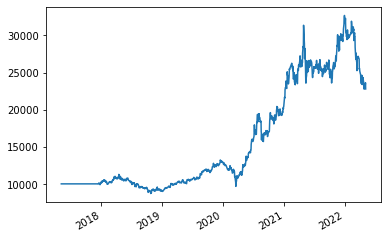

In [7]:
result_rsi_ema._equity_curve.Equity.plot()

In [72]:
result_rsi_ema_2 = bt_rsi_ema.optimize(n1 = range(5, 50, 5),
                                       n2 = range(5, 100, 5),
                                       n3 = range(5, 50, 5),
                                       method = 'skopt', # grid: exhaustive search, skopt: close-to-optimal
                                      )
result_rsi_ema_2._strategy

Backtest.optimize:   0%|          | 0/200 [00:00<?, ?it/s]

<Strategy RSI_EMA(n1=16,n2=21,n3=9)>

In [40]:
bt_rsi_ema.plot()

Row(id='5400', ...)

<AxesSubplot:>

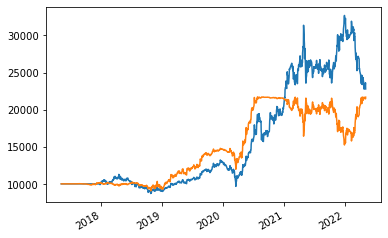

In [41]:
result_rsi_ema._equity_curve.Equity.plot()
result_rsi_ema_2._equity_curve.Equity.plot()

In [42]:
result_rsi_ema

Start                     2017-05-08 00:00:00
End                       2022-05-06 00:00:00
Duration                   1824 days 00:00:00
Exposure Time [%]                   87.356322
Equity Final [$]                 22788.907272
Equity Peak [$]                  32694.907272
Return [%]                         127.889073
Buy & Hold Return [%]              357.059865
Return (Ann.) [%]                   18.580085
Volatility (Ann.) [%]                31.66242
Sharpe Ratio                         0.586818
Sortino Ratio                        1.074756
Calmar Ratio                         0.611633
Max. Drawdown [%]                   -30.37782
Avg. Drawdown [%]                   -5.421265
Max. Drawdown Duration      488 days 00:00:00
Avg. Drawdown Duration       39 days 00:00:00
# Trades                                    7
Win Rate [%]                        85.714286
Best Trade [%]                     220.595093
Worst Trade [%]                    -15.829255
Avg. Trade [%]                    

In [43]:
result_rsi_ema_2

Start                     2017-05-08 00:00:00
End                       2022-05-06 00:00:00
Duration                   1824 days 00:00:00
Exposure Time [%]                   94.581281
Equity Final [$]                 21677.986509
Equity Peak [$]                  21723.762983
Return [%]                         116.779865
Buy & Hold Return [%]              357.059865
Return (Ann.) [%]                   17.360286
Volatility (Ann.) [%]               26.879921
Sharpe Ratio                         0.645846
Sortino Ratio                        1.167141
Calmar Ratio                         0.581832
Max. Drawdown [%]                  -29.837264
Avg. Drawdown [%]                   -3.568137
Max. Drawdown Duration      648 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                   86
Win Rate [%]                        86.046512
Best Trade [%]                     123.180161
Worst Trade [%]                    -25.768978
Avg. Trade [%]                    